In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "all_z"
key = "lambda"
quantile = "1"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  3.15it/s]

11it [00:00,  4.44it/s]

23it [00:00,  6.23it/s]

29it [00:00,  8.52it/s]

41it [00:00, 11.80it/s]

52it [00:00, 16.05it/s]

62it [00:00, 21.42it/s]

74it [00:01, 28.28it/s]

86it [00:01, 36.46it/s]

98it [00:01, 45.76it/s]

109it [00:01, 55.46it/s]

121it [00:01, 65.19it/s]

132it [00:01, 66.09it/s]

143it [00:01, 74.57it/s]

153it [00:01, 79.33it/s]

163it [00:01, 79.57it/s]

174it [00:02, 86.58it/s]

185it [00:02, 92.43it/s]

196it [00:02, 96.95it/s]

207it [00:02, 92.71it/s]

219it [00:02, 97.78it/s]

231it [00:02, 101.32it/s]

242it [00:02, 96.05it/s] 

253it [00:02, 99.35it/s]

265it [00:02, 102.82it/s]

277it [00:03, 105.17it/s]

288it [00:03, 106.17it/s]

300it [00:03, 107.74it/s]

312it [00:03, 108.45it/s]

323it [00:03, 108.69it/s]

334it [00:03, 108.26it/s]

346it [00:03, 108.95it/s]

358it [00:03, 109.38it/s]

370it [00:03, 110.02it/s]

382it [00:04, 110.52it/s]

394it [00:04, 109.62it/s]

405it [00:04, 109.08it/s]

417it [00:04, 109.68it/s]

428it [00:04, 109.62it/s]

440it [00:04, 110.47it/s]

452it [00:04, 110.25it/s]

464it [00:04, 109.02it/s]

476it [00:04, 109.93it/s]

488it [00:04, 110.97it/s]

500it [00:05, 108.81it/s]

512it [00:05, 110.25it/s]

524it [00:05, 111.10it/s]

536it [00:05, 112.13it/s]

548it [00:05, 112.50it/s]

560it [00:05, 112.16it/s]

572it [00:05, 111.55it/s]

584it [00:05, 105.12it/s]

596it [00:05, 107.47it/s]

607it [00:06, 106.62it/s]

618it [00:06, 107.57it/s]

630it [00:06, 108.57it/s]

642it [00:06, 109.33it/s]

653it [00:06, 98.05it/s] 

664it [00:06, 92.16it/s]

675it [00:06, 95.92it/s]

687it [00:06, 100.14it/s]

698it [00:07, 96.75it/s] 

710it [00:07, 100.59it/s]

722it [00:07, 104.85it/s]

734it [00:07, 106.95it/s]

746it [00:07, 109.22it/s]

758it [00:07, 110.76it/s]

770it [00:07, 111.37it/s]

782it [00:07, 112.85it/s]

794it [00:07, 111.98it/s]

806it [00:07, 102.34it/s]

817it [00:08, 94.91it/s] 

829it [00:08, 100.37it/s]

841it [00:08, 104.50it/s]

853it [00:08, 106.60it/s]

865it [00:08, 108.15it/s]

877it [00:08, 110.07it/s]

889it [00:08, 112.01it/s]

901it [00:08, 112.78it/s]

913it [00:08, 113.62it/s]

925it [00:09, 113.44it/s]

937it [00:09, 113.62it/s]

949it [00:09, 111.91it/s]

961it [00:09, 112.48it/s]

973it [00:09, 111.63it/s]

985it [00:09, 111.86it/s]

997it [00:09, 112.00it/s]

1009it [00:09, 112.43it/s]

1021it [00:09, 107.96it/s]

1032it [00:10, 107.31it/s]

1043it [00:10, 102.30it/s]

1055it [00:10, 104.78it/s]

1066it [00:10, 105.98it/s]

1077it [00:10, 103.42it/s]

1088it [00:10, 103.08it/s]

1099it [00:10, 101.99it/s]

1111it [00:10, 104.62it/s]

1123it [00:10, 106.61it/s]

1135it [00:11, 108.20it/s]

1146it [00:11, 105.36it/s]

1157it [00:11, 105.44it/s]

1169it [00:11, 107.36it/s]

1181it [00:11, 108.78it/s]

1193it [00:11, 110.23it/s]

1205it [00:11, 94.65it/s] 

1215it [00:11, 87.64it/s]

1225it [00:12, 81.40it/s]

1235it [00:12, 85.63it/s]

1246it [00:12, 90.34it/s]

1257it [00:12, 95.43it/s]

1268it [00:12, 98.32it/s]

1280it [00:12, 102.36it/s]

1292it [00:12, 105.09it/s]

1303it [00:12, 103.78it/s]

1314it [00:12, 102.39it/s]

1326it [00:12, 104.67it/s]

1338it [00:13, 107.14it/s]

1350it [00:13, 108.72it/s]

1362it [00:13, 109.43it/s]

1374it [00:13, 110.42it/s]

1386it [00:13, 92.67it/s] 

1396it [00:13, 89.70it/s]

1408it [00:13, 95.07it/s]

1420it [00:13, 99.60it/s]

1431it [00:14, 97.58it/s]

1443it [00:14, 101.39it/s]

1454it [00:14, 103.80it/s]

1465it [00:14, 104.07it/s]

1476it [00:14, 105.02it/s]

1488it [00:14, 107.09it/s]

1499it [00:14, 93.23it/s] 

1510it [00:14, 97.20it/s]

1522it [00:14, 100.73it/s]

1533it [00:15, 103.20it/s]

1544it [00:15, 104.78it/s]

1555it [00:15, 100.94it/s]

1567it [00:15, 103.73it/s]

1579it [00:15, 106.18it/s]

1590it [00:15, 104.16it/s]

1601it [00:15, 105.39it/s]

1613it [00:15, 107.56it/s]

1624it [00:15, 108.27it/s]

1635it [00:15, 107.85it/s]

1647it [00:16, 109.10it/s]

1658it [00:16, 108.66it/s]

1670it [00:16, 109.09it/s]

1681it [00:16, 109.09it/s]

1692it [00:16, 109.31it/s]

1704it [00:16, 110.01it/s]

1716it [00:16, 110.20it/s]

1728it [00:16, 110.79it/s]

1740it [00:16, 111.16it/s]

1752it [00:17, 110.85it/s]

1764it [00:17, 95.74it/s] 

1774it [00:17, 90.95it/s]

1785it [00:17, 95.84it/s]

1796it [00:17, 98.55it/s]

1807it [00:17, 101.03it/s]

1819it [00:17, 103.82it/s]

1830it [00:17, 105.21it/s]

1842it [00:17, 106.87it/s]

1854it [00:18, 108.30it/s]

1865it [00:18, 107.17it/s]

1876it [00:18, 91.25it/s] 

1887it [00:18, 96.03it/s]

1897it [00:18, 92.98it/s]

1909it [00:18, 97.64it/s]

1920it [00:18, 100.51it/s]

1932it [00:18, 103.78it/s]

1943it [00:18, 105.38it/s]

1954it [00:19, 106.65it/s]

1966it [00:19, 107.87it/s]

1978it [00:19, 109.11it/s]

1989it [00:19, 109.04it/s]

2000it [00:19, 106.33it/s]

2012it [00:19, 107.56it/s]

2023it [00:19, 92.13it/s] 

2034it [00:19, 96.04it/s]

2045it [00:19, 99.66it/s]

2056it [00:20, 99.44it/s]

2067it [00:20, 102.27it/s]

2078it [00:20, 100.98it/s]

2089it [00:20, 102.66it/s]

2100it [00:20, 93.07it/s] 

2111it [00:20, 96.40it/s]

2123it [00:20, 100.96it/s]

2135it [00:20, 104.40it/s]

2146it [00:20, 100.58it/s]

2157it [00:21, 103.13it/s]

2169it [00:21, 105.58it/s]

2180it [00:21, 106.40it/s]

2191it [00:21, 107.44it/s]

2202it [00:21, 107.59it/s]

2213it [00:21, 106.85it/s]

2224it [00:21, 107.01it/s]

2235it [00:21, 107.73it/s]

2246it [00:21, 108.39it/s]

2257it [00:22, 92.11it/s] 

2267it [00:22, 84.58it/s]

2276it [00:22, 75.35it/s]

2287it [00:22, 81.64it/s]

2299it [00:22, 88.60it/s]

2310it [00:22, 93.96it/s]

2322it [00:22, 98.57it/s]

2333it [00:22, 101.36it/s]

2344it [00:22, 101.35it/s]

2356it [00:23, 104.54it/s]

2368it [00:23, 106.91it/s]

2380it [00:23, 108.17it/s]

2391it [00:23, 108.64it/s]

2402it [00:23, 102.83it/s]

2414it [00:23, 105.56it/s]

2425it [00:23, 93.55it/s] 

2435it [00:23, 87.21it/s]

2446it [00:23, 91.83it/s]

2458it [00:24, 97.02it/s]

2469it [00:24, 98.28it/s]

2480it [00:24, 99.65it/s]

2492it [00:24, 102.92it/s]

2503it [00:24, 104.25it/s]

2515it [00:24, 106.16it/s]

2526it [00:24, 105.61it/s]

2537it [00:24, 93.10it/s] 

2547it [00:25, 83.04it/s]

2556it [00:25, 79.36it/s]

2565it [00:25, 82.06it/s]

2577it [00:25, 89.25it/s]

2589it [00:25, 94.80it/s]

2600it [00:25, 98.49it/s]

2612it [00:25, 101.98it/s]

2623it [00:25, 104.19it/s]

2634it [00:25, 105.69it/s]

2646it [00:25, 107.99it/s]

2658it [00:26, 108.77it/s]

2669it [00:26, 107.75it/s]

2680it [00:26, 107.95it/s]

2691it [00:26, 94.68it/s] 

2701it [00:26, 86.20it/s]

2710it [00:26, 86.88it/s]

2722it [00:26, 93.27it/s]

2734it [00:26, 97.80it/s]

2746it [00:27, 102.22it/s]

2758it [00:27, 104.17it/s]

2770it [00:27, 106.45it/s]

2782it [00:27, 107.66it/s]

2794it [00:27, 108.67it/s]

2805it [00:27, 108.54it/s]

2816it [00:27, 108.38it/s]

2827it [00:27, 92.58it/s] 

2837it [00:27, 83.76it/s]

2848it [00:28, 88.35it/s]

2859it [00:28, 93.76it/s]

2871it [00:28, 98.78it/s]

2882it [00:28, 88.09it/s]

2893it [00:28, 91.64it/s]

2903it [00:28, 88.76it/s]

2915it [00:28, 95.00it/s]

2926it [00:28, 98.83it/s]

2938it [00:28, 102.39it/s]

2949it [00:29, 104.30it/s]

2961it [00:29, 106.71it/s]

2973it [00:29, 108.17it/s]

2985it [00:29, 109.17it/s]

2996it [00:29, 109.13it/s]

3008it [00:29, 110.16it/s]

3020it [00:29, 111.14it/s]

3032it [00:29, 110.26it/s]

3044it [00:29, 109.61it/s]

3055it [00:30, 107.91it/s]

3066it [00:30, 107.41it/s]

3077it [00:30, 108.04it/s]

3088it [00:30, 104.30it/s]

3099it [00:30, 96.32it/s] 

3109it [00:30, 95.44it/s]

3120it [00:30, 99.14it/s]

3131it [00:30, 100.72it/s]

3143it [00:30, 103.32it/s]

3154it [00:31, 104.29it/s]

3166it [00:31, 106.15it/s]

3178it [00:31, 107.43it/s]

3190it [00:31, 108.59it/s]

3201it [00:31, 106.52it/s]

3212it [00:31, 104.76it/s]

3224it [00:31, 105.97it/s]

3236it [00:31, 107.80it/s]

3248it [00:31, 108.65it/s]

3260it [00:31, 109.58it/s]

3271it [00:32, 108.37it/s]

3282it [00:32, 94.05it/s] 

3292it [00:32, 87.09it/s]

3302it [00:32, 83.02it/s]

3311it [00:32, 80.22it/s]

3320it [00:32, 76.23it/s]

3330it [00:32, 80.69it/s]

3342it [00:32, 87.92it/s]

3354it [00:33, 93.82it/s]

3365it [00:33, 98.02it/s]

3377it [00:33, 101.86it/s]

3388it [00:33, 103.92it/s]

3399it [00:33, 103.91it/s]

3411it [00:33, 105.83it/s]

3423it [00:33, 107.46it/s]

3434it [00:33, 90.41it/s] 

3446it [00:33, 96.08it/s]

3458it [00:34, 100.03it/s]

3469it [00:34, 96.02it/s] 

3481it [00:34, 100.61it/s]

3493it [00:34, 103.85it/s]

3505it [00:34, 106.25it/s]

3516it [00:34, 93.89it/s] 

3526it [00:34, 95.33it/s]

3536it [00:34, 96.45it/s]

3548it [00:35, 100.62it/s]

3559it [00:35, 102.27it/s]

3571it [00:35, 104.68it/s]

3582it [00:35, 102.63it/s]

3593it [00:35, 90.00it/s] 

3604it [00:35, 94.89it/s]

3616it [00:35, 99.52it/s]

3627it [00:35, 94.75it/s]

3637it [00:35, 88.27it/s]

3647it [00:36, 86.66it/s]

3659it [00:36, 92.76it/s]

3670it [00:36, 97.16it/s]

3681it [00:36, 100.31it/s]

3693it [00:36, 103.48it/s]

3705it [00:36, 105.77it/s]

3717it [00:36, 108.25it/s]

3729it [00:36, 109.90it/s]

3741it [00:36, 109.14it/s]

3753it [00:37, 110.13it/s]

3765it [00:37, 110.74it/s]

3777it [00:37, 111.03it/s]

3789it [00:37, 110.53it/s]

3801it [00:37, 102.63it/s]

3812it [00:37, 90.05it/s] 

3822it [00:37, 85.15it/s]

3831it [00:37, 80.84it/s]

3840it [00:38, 81.30it/s]

3852it [00:38, 88.54it/s]

3864it [00:38, 94.20it/s]

3875it [00:38, 97.90it/s]

3886it [00:38, 100.86it/s]

3898it [00:38, 104.28it/s]

3909it [00:38, 99.03it/s] 

3921it [00:38, 102.52it/s]

3933it [00:38, 104.96it/s]

3945it [00:38, 106.78it/s]

3957it [00:39, 108.48it/s]

3968it [00:39, 106.81it/s]

3980it [00:39, 108.40it/s]

3992it [00:39, 110.12it/s]

4004it [00:39, 110.84it/s]

4016it [00:39, 111.30it/s]

4028it [00:39, 112.08it/s]

4040it [00:39, 112.10it/s]

4052it [00:39, 111.90it/s]

4064it [00:40, 111.14it/s]

4076it [00:40, 109.14it/s]

4088it [00:40, 109.35it/s]

4099it [00:40, 102.59it/s]

4111it [00:40, 105.26it/s]

4123it [00:40, 107.18it/s]

4135it [00:40, 108.61it/s]

4146it [00:40, 108.79it/s]

4157it [00:40, 108.88it/s]

4158it [00:40, 101.56it/s]


0it [00:00, ?it/s]

12it [00:00, 113.59it/s]

Number of empty sat catalogs is 2


24it [00:00, 112.67it/s]

36it [00:00, 114.39it/s]

45it [00:00, 102.09it/s]

56it [00:00, 103.49it/s]

68it [00:00, 107.47it/s]

80it [00:00, 110.29it/s]

92it [00:00, 112.45it/s]

104it [00:00, 114.18it/s]

116it [00:01, 110.15it/s]

128it [00:01, 111.97it/s]

140it [00:01, 113.61it/s]

152it [00:01, 105.52it/s]

164it [00:01, 107.34it/s]

175it [00:01, 97.01it/s] 

187it [00:01, 101.76it/s]

199it [00:01, 105.86it/s]

211it [00:01, 108.63it/s]

223it [00:02, 108.47it/s]

234it [00:02, 101.80it/s]

245it [00:02, 96.56it/s] 

257it [00:02, 102.36it/s]

269it [00:02, 105.86it/s]

280it [00:02, 100.50it/s]

291it [00:02, 102.94it/s]

303it [00:02, 107.09it/s]

315it [00:02, 110.18it/s]

327it [00:03, 111.94it/s]

339it [00:03, 110.91it/s]

351it [00:03, 112.82it/s]

363it [00:03, 111.43it/s]

375it [00:03, 113.39it/s]

387it [00:03, 114.54it/s]

399it [00:03, 107.94it/s]

410it [00:03, 97.30it/s] 

423it [00:03, 103.27it/s]

435it [00:04, 107.75it/s]

448it [00:04, 110.98it/s]

460it [00:04, 112.56it/s]

472it [00:04, 113.76it/s]

484it [00:04, 109.70it/s]

496it [00:04, 111.50it/s]

508it [00:04, 112.33it/s]

520it [00:04, 113.56it/s]

532it [00:04, 114.33it/s]

544it [00:04, 115.86it/s]

556it [00:05, 115.74it/s]

568it [00:05, 113.20it/s]

580it [00:05, 114.71it/s]

593it [00:05, 116.36it/s]

605it [00:05, 111.65it/s]

617it [00:05, 113.05it/s]

629it [00:05, 114.65it/s]

641it [00:05, 111.93it/s]

653it [00:05, 113.94it/s]

665it [00:06, 115.46it/s]

677it [00:06, 116.44it/s]

689it [00:06, 112.78it/s]

701it [00:06, 113.49it/s]

713it [00:06, 83.29it/s] 

725it [00:06, 91.47it/s]

737it [00:06, 98.47it/s]

750it [00:06, 104.15it/s]

762it [00:07, 108.16it/s]

774it [00:07, 111.20it/s]

786it [00:07, 113.32it/s]

798it [00:07, 113.59it/s]

811it [00:07, 115.61it/s]

823it [00:07, 114.12it/s]

835it [00:07, 93.79it/s] 

847it [00:07, 99.10it/s]

860it [00:07, 105.56it/s]

872it [00:08, 101.30it/s]

885it [00:08, 107.18it/s]

897it [00:08, 109.10it/s]

910it [00:08, 113.52it/s]

923it [00:08, 117.37it/s]

936it [00:08, 119.37it/s]

949it [00:08, 120.58it/s]

962it [00:08, 120.05it/s]

975it [00:08, 120.97it/s]

988it [00:09, 121.07it/s]

1001it [00:09, 121.26it/s]

1014it [00:09, 121.22it/s]

1027it [00:09, 121.11it/s]

1040it [00:09, 121.91it/s]

1053it [00:09, 102.23it/s]

1064it [00:09, 103.94it/s]

1075it [00:09, 105.09it/s]

1088it [00:09, 109.60it/s]

1101it [00:10, 113.23it/s]

1114it [00:10, 116.35it/s]

1127it [00:10, 119.39it/s]

1140it [00:10, 120.84it/s]

1153it [00:10, 121.58it/s]

1166it [00:10, 121.37it/s]

1179it [00:10, 121.38it/s]

1192it [00:10, 121.03it/s]

1205it [00:10, 120.99it/s]

1218it [00:11, 104.16it/s]

1229it [00:11, 95.07it/s] 

1239it [00:11, 87.30it/s]

1249it [00:11, 85.65it/s]

1258it [00:11, 82.41it/s]

1267it [00:11, 81.83it/s]

1276it [00:11, 82.04it/s]

1287it [00:11, 88.67it/s]

1300it [00:11, 96.64it/s]

1313it [00:12, 103.11it/s]

1326it [00:12, 108.19it/s]

1339it [00:12, 112.25it/s]

1352it [00:12, 114.88it/s]

1364it [00:12, 113.54it/s]

1377it [00:12, 116.00it/s]

1390it [00:12, 118.45it/s]

1402it [00:12, 118.82it/s]

1415it [00:12, 119.56it/s]

1428it [00:13, 119.18it/s]

1440it [00:13, 119.32it/s]

1453it [00:13, 120.09it/s]

1466it [00:13, 120.42it/s]

1479it [00:13, 117.52it/s]

1492it [00:13, 118.44it/s]

1505it [00:13, 119.34it/s]

1517it [00:13, 117.06it/s]

1529it [00:13, 103.69it/s]

1542it [00:14, 108.31it/s]

1554it [00:14, 101.68it/s]

1565it [00:14, 98.96it/s] 

1577it [00:14, 103.68it/s]

1588it [00:14, 98.27it/s] 

1599it [00:14, 96.43it/s]

1612it [00:14, 102.62it/s]

1625it [00:14, 107.74it/s]

1636it [00:14, 104.81it/s]

1649it [00:15, 109.15it/s]

1661it [00:15, 111.29it/s]

1673it [00:15, 112.19it/s]

1685it [00:15, 113.62it/s]

1697it [00:15, 108.18it/s]

1708it [00:15, 97.88it/s] 

1720it [00:15, 101.81it/s]

1732it [00:15, 106.64it/s]

1743it [00:15, 100.84it/s]

1755it [00:16, 105.36it/s]

1766it [00:16, 105.37it/s]

1779it [00:16, 109.63it/s]

1792it [00:16, 112.82it/s]

1804it [00:16, 102.33it/s]

1815it [00:16, 102.06it/s]

1828it [00:16, 107.03it/s]

1841it [00:16, 110.92it/s]

1854it [00:16, 113.62it/s]

1866it [00:17, 115.23it/s]

1878it [00:17, 116.52it/s]

1891it [00:17, 117.32it/s]

1903it [00:17, 117.77it/s]

1915it [00:17, 113.20it/s]

1927it [00:17, 100.26it/s]

1938it [00:17, 93.32it/s] 

1948it [00:17, 88.45it/s]

1958it [00:18, 89.85it/s]

1968it [00:18, 85.75it/s]

1977it [00:18, 83.65it/s]

1988it [00:18, 89.55it/s]

2000it [00:18, 96.23it/s]

2013it [00:18, 102.76it/s]

2025it [00:18, 107.33it/s]

2038it [00:18, 110.68it/s]

2050it [00:18, 112.63it/s]

2062it [00:19, 114.21it/s]

2074it [00:19, 115.15it/s]

2086it [00:19, 115.40it/s]

2098it [00:19, 112.88it/s]

2110it [00:19, 111.16it/s]

2122it [00:19, 101.33it/s]

2133it [00:19, 92.61it/s] 

2144it [00:19, 95.35it/s]

2156it [00:19, 101.23it/s]

2168it [00:20, 106.14it/s]

2180it [00:20, 109.82it/s]

2192it [00:20, 112.39it/s]

2204it [00:20, 109.54it/s]

2217it [00:20, 112.69it/s]

2229it [00:20, 113.93it/s]

2242it [00:20, 115.97it/s]

2255it [00:20, 117.77it/s]

2268it [00:20, 118.47it/s]

2281it [00:20, 119.71it/s]

2294it [00:21, 114.55it/s]

2307it [00:21, 116.21it/s]

2319it [00:21, 117.13it/s]

2332it [00:21, 118.64it/s]

2345it [00:21, 120.18it/s]

2358it [00:21, 120.56it/s]

2371it [00:21, 121.07it/s]

2384it [00:21, 121.40it/s]

2397it [00:21, 121.59it/s]

2410it [00:22, 121.74it/s]

2423it [00:22, 121.48it/s]

2436it [00:22, 120.96it/s]

2449it [00:22, 120.43it/s]

2462it [00:22, 120.32it/s]

2475it [00:22, 120.36it/s]

2488it [00:22, 119.82it/s]

2500it [00:22, 119.79it/s]

2513it [00:22, 119.72it/s]

2526it [00:23, 120.63it/s]

2539it [00:23, 119.98it/s]

2552it [00:23, 120.78it/s]

2565it [00:23, 120.60it/s]

2578it [00:23, 121.97it/s]

2591it [00:23, 121.61it/s]

2604it [00:23, 105.78it/s]

2616it [00:23, 109.63it/s]

2629it [00:23, 112.65it/s]

2641it [00:24, 96.80it/s] 

2652it [00:24, 91.73it/s]

2662it [00:24, 86.21it/s]

2674it [00:24, 93.93it/s]

2687it [00:24, 99.06it/s]

2698it [00:24, 96.33it/s]

2710it [00:24, 102.20it/s]

2722it [00:24, 106.62it/s]

2735it [00:25, 110.14it/s]

2747it [00:25, 111.71it/s]

2759it [00:25, 107.88it/s]

2771it [00:25, 110.84it/s]

2784it [00:25, 113.86it/s]

2796it [00:25, 111.73it/s]

2808it [00:25, 111.08it/s]

2821it [00:25, 114.38it/s]

2833it [00:25, 100.37it/s]

2844it [00:26, 93.12it/s] 

2856it [00:26, 98.68it/s]

2868it [00:26, 103.58it/s]

2881it [00:26, 108.32it/s]

2894it [00:26, 111.33it/s]

2906it [00:26, 88.27it/s] 

2916it [00:26, 86.90it/s]

2929it [00:26, 94.90it/s]

2942it [00:27, 101.60it/s]

2955it [00:27, 107.40it/s]

2968it [00:27, 111.56it/s]

2980it [00:27, 113.41it/s]

2993it [00:27, 115.91it/s]

3005it [00:27, 116.34it/s]

3017it [00:27, 117.22it/s]

3030it [00:27, 119.03it/s]

3042it [00:27, 111.33it/s]

3054it [00:27, 113.52it/s]

3066it [00:28, 115.29it/s]

3079it [00:28, 116.84it/s]

3092it [00:28, 118.17it/s]

3104it [00:28, 118.63it/s]

3116it [00:28, 118.88it/s]

3129it [00:28, 119.75it/s]

3141it [00:28, 115.27it/s]

3154it [00:28, 117.01it/s]

3166it [00:28, 117.76it/s]

3178it [00:29, 117.62it/s]

3191it [00:29, 119.48it/s]

3203it [00:29, 114.68it/s]

3215it [00:29, 115.73it/s]

3227it [00:29, 97.93it/s] 

3238it [00:29, 99.91it/s]

3249it [00:29, 98.03it/s]

3261it [00:29, 102.91it/s]

3274it [00:29, 108.40it/s]

3286it [00:30, 110.78it/s]

3299it [00:30, 113.55it/s]

3312it [00:30, 115.40it/s]

3324it [00:30, 108.11it/s]

3336it [00:30, 110.65it/s]

3349it [00:30, 113.76it/s]

3361it [00:30, 102.22it/s]

3373it [00:30, 106.96it/s]

3386it [00:30, 111.39it/s]

3398it [00:31, 113.66it/s]

3410it [00:31, 112.78it/s]

3422it [00:31, 112.32it/s]

3434it [00:31, 110.33it/s]

3446it [00:31, 110.25it/s]

3458it [00:31, 112.13it/s]

3470it [00:31, 97.51it/s] 

3481it [00:31, 100.27it/s]

3493it [00:31, 105.23it/s]

3505it [00:32, 107.45it/s]

3518it [00:32, 111.68it/s]

3531it [00:32, 114.27it/s]

3543it [00:32, 115.91it/s]

3555it [00:32, 116.91it/s]

3568it [00:32, 118.27it/s]

3581it [00:32, 119.20it/s]

3594it [00:32, 119.50it/s]

3606it [00:32, 119.45it/s]

3618it [00:32, 117.97it/s]

3631it [00:33, 118.73it/s]

3643it [00:33, 118.90it/s]

3655it [00:33, 119.07it/s]

3667it [00:33, 113.02it/s]

3679it [00:33, 96.84it/s] 

3690it [00:33, 90.54it/s]

3700it [00:33, 87.61it/s]

3712it [00:33, 95.14it/s]

3724it [00:34, 101.14it/s]

3736it [00:34, 105.61it/s]

3748it [00:34, 109.38it/s]

3760it [00:34, 112.20it/s]

3773it [00:34, 112.23it/s]

3785it [00:34, 107.76it/s]

3796it [00:34, 99.27it/s] 

3808it [00:34, 102.98it/s]

3820it [00:34, 107.36it/s]

3832it [00:35, 109.87it/s]

3844it [00:35, 111.93it/s]

3857it [00:35, 114.51it/s]

3869it [00:35, 115.12it/s]

3882it [00:35, 116.70it/s]

3894it [00:35, 115.40it/s]

3907it [00:35, 117.11it/s]

3919it [00:35, 103.92it/s]

3931it [00:35, 106.12it/s]

3943it [00:36, 108.95it/s]

3955it [00:36, 111.18it/s]

3967it [00:36, 110.81it/s]

3979it [00:36, 111.88it/s]

3991it [00:36, 112.52it/s]

4003it [00:36, 108.22it/s]

4015it [00:36, 108.95it/s]

4026it [00:36, 100.04it/s]

4037it [00:36, 94.90it/s] 

4050it [00:37, 101.58it/s]

4062it [00:37, 106.27it/s]

4075it [00:37, 110.72it/s]

4088it [00:37, 113.74it/s]

4100it [00:37, 113.80it/s]

4112it [00:37, 99.54it/s] 

4123it [00:37, 93.10it/s]

4135it [00:37, 98.39it/s]

4147it [00:37, 103.41it/s]

4158it [00:38, 109.27it/s]

Number of empty sat catalogs is 2


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

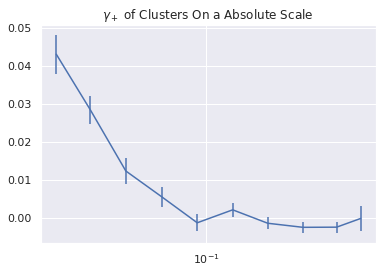

Aggregated xi:
[-21.7531 -30.1585 -19.9945 -14.8264   5.5317 -14.7462  14.2525  32.3391
  28.4561   0.2693]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -2184.938   -4104.5337  -5482.1475  -7775.8824 -10446.6981 -13459.7294
 -14821.425  -12922.3774  -6241.5773   -377.9867]
------------------------------------------------------------------------------
Aggregated npairs:
[  505.  1062.  1619.  2683.  4317.  6937. 10112. 13052. 11666.  1806.]
------------------------------------------------------------------------------
Mean xi:
[-0.0431 -0.0284 -0.0123 -0.0055  0.0013 -0.0021  0.0014  0.0025  0.0024
  0.0001]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3266 -3.8649 -3.3861 -2.8982 -2.4199 -1.9403 -1.4657 -0.9901 -0.535
 -0.2093]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

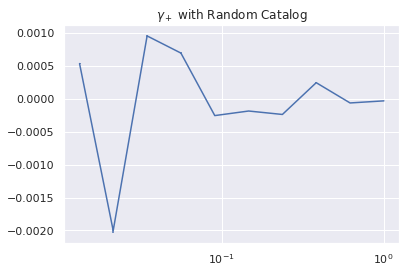

[ 5.3807e-04 -2.0032e-03  9.5860e-04  6.9755e-04 -2.5362e-04 -1.8407e-04
 -2.3639e-04  2.4706e-04 -6.1347e-05 -2.9438e-05]
[-8.3444e-06  3.1065e-05 -1.4866e-05 -1.0818e-05  3.9331e-06  2.8546e-06
  3.6659e-06 -3.8315e-06  9.5137e-07  4.5652e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

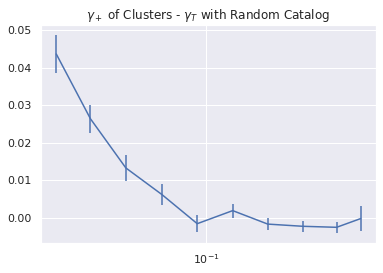

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

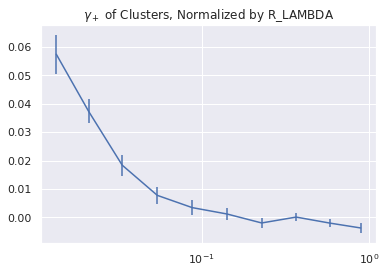

Aggregated xi:
[-14.6488 -27.5392 -23.4326 -15.2592 -11.2576  -6.4217  15.9906  -1.4087
  26.6903  30.4809]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1096.0165  -2840.6128  -4321.8326  -5717.7893  -7927.4485 -10300.2628
 -12124.0768 -11383.7815  -7131.4875   -954.4097]
------------------------------------------------------------------------------
Aggregated npairs:
[  255.   737.  1274.  1965.  3262.  5272.  8214. 11352. 13294.  8221.]
------------------------------------------------------------------------------
Mean xi:
[-0.0574 -0.0374 -0.0184 -0.0078 -0.0035 -0.0012  0.0019 -0.0001  0.002
  0.0037]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2981 -3.8543 -3.3923 -2.9098 -2.4302 -1.9538 -1.476  -1.0028 -0.5364
 -0.1161]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)